# Проект e-commerce: вариант 1 
### Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. (10 баллов)

6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). (35 баллов)

In [1]:
import pandas as pd
import datetime
from datetime import timedelta

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from scipy import stats

import requests
from urllib.parse import urlencode

In [2]:
# публичные ссылки на файлы в Яндекс.Диск
customers_public_key = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
orders_public_key = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
items_public_key = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

In [3]:
def get_yandex_download_url(public_key):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
df_c = pd.read_csv(get_yandex_download_url(customers_public_key))
df_o = pd.read_csv(get_yandex_download_url(orders_public_key), parse_dates=[3,4,5,6,7])
# сразу спарсим нужные столбцы в формате дат
df_i = pd.read_csv(get_yandex_download_url(items_public_key))

In [5]:
df_c.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
df_o.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [7]:
df_i.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

Для начала проверим, какие у нас есть статусы в таблице с заказами:

In [8]:
df_o.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Попробуем учесть в нашем решении все условия, которые нам доступны.

Во-первых, сразу уберем статусы, которые нас не устраивают: 'canceled', 'unavailable'.

Далее - 'invoiced' (счет только выставлен), 'created' (только создан) - нам тоже наверняка не интересны, но их пока оставим.
Формируем новый суб-датафрейм:

In [9]:
df_finalized_orders = df_o.query('order_status != "canceled" and order_status != "unavailable"')

Отлично, будем считать, что заказы со статусами 'delivered'и 'shipped' нас полностью устраивают, пока оставим их в покое

Разберемся с другими статусами с помощью следующей конструкции:

In [10]:
df_finalized_orders[df_finalized_orders.order_status == 'invoiced'] \
                   .query('order_approved_at == "NaT"')['order_id'].nunique()

0

Вместо 'invoiced' поочередно подставим оставшиеся статусы. Проверка показывает, что статус 'created' во всех пяти случаях не имеет даты оплаты, значит его тоже отбрасываем.

Таким образом, мы получим два варианта ответа:

1) Учитываем только shipped и delivered заказы;

2) прибавляем к ним заказы в процессе, но оплаченные

Делаем мы так, потому что не знаем, на каком этапе заказ может отмениться или стать недоступным

In [11]:
# избавляемся от ненужных статуса и стобцов
df_finalized_orders = df_finalized_orders.query('order_status != "created"')[['order_id', 'customer_id', 'order_status']]

Теперь нам нужны данные по клиентам, добавим их в нашу таблицу

In [12]:
df_unique_clients = df_c[['customer_unique_id', 'customer_id']]

orders_with_unique_id = pd.merge(df_finalized_orders, df_unique_clients, how='left')
orders_with_unique_id.head()

,order_id,customer_id,order_status,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,72632f0f9dd73dfee390c9b22eb56dd6


In [13]:
# Тогда всего покупателей с 1 заказом:

orders_with_unique_id.groupby('customer_unique_id', as_index=False) \
                     .agg({'order_id': 'count'}) \
                     .query('order_id == 1').shape[0]
# Ответ: 92099

92099

In [14]:
# Либо: Тогда всео покупателей с 1 заказом, который либо уже доставлен, либо уже отправлен:

orders_with_unique_id[orders_with_unique_id['order_status'].isin(['delivered', 'shipped'])] \
                     .groupby('customer_unique_id', as_index=False) \
                     .agg({'order_id': 'count'}) \
                     .query('order_id == 1').shape[0]
# Ответ: 91538

91538

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

Снова обратимся к нашей таблице с заказами.
Сразу откинем заказы со статусом 'delivered'

In [15]:
df_monthly = df_o[df_o.order_status != 'delivered']
df_monthly.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


Проверим, есть ли в нашем новом ДФ заказы с указанной датой доставки (забегая вперед: есть), и посмотрим на них:

In [16]:
df_monthly.query('order_delivered_customer_date != "NaT"').order_status.value_counts()

canceled    6
Name: order_status, dtype: int64

Так, мы имеем 6 заказов со статусом 'canceled'. Странная ситуация, но думаю, что ошибиться проще со статусом заказа, чем с подробным временем, с точностью до минуты. Не будем учитывать эти строки

In [17]:
df_monthly = df_monthly.query('order_delivered_customer_date == "NaT"')

Будем считать, что обещанная дата доставки формируется сразу при заказе.
Тогда группировку для вычисления среднего будем считать именно по этому столбцу

In [18]:
df_monthly['estimated_delivery'] = df_monthly.order_estimated_delivery_date.apply(lambda x: x.strftime('%Y-%m'))

In [19]:
df_monthly = df_monthly[['order_status','estimated_delivery', 'order_id']]
df_monthly.head()

,order_status,estimated_delivery,order_id
6,invoiced,2017-05,136cce7faa42fdb2cefd53fdc79a6098
44,shipped,2018-06,ee64d42b8cf066f35eac1cf57de1aa85
103,invoiced,2018-08,0760a852e4e9d89eb77bf631eaaf1c84
128,processing,2017-10,15bed8e2fec7fdbadb186b57c46c92f2
154,shipped,2018-02,6942b8da583c2f9957e990d028607019


In [20]:
df_monthly1 = df_monthly.groupby(['estimated_delivery', 'order_status']) \
          .agg({'order_id': 'count'}).reset_index()

In [21]:
# Теперь посчитаем среднее
df_monthly1.groupby('order_status', as_index=False) \
           .agg({'order_id': 'mean'}) \
           .round(1) \
           .query('order_status != "shipped"') #последний штрих - 'shipped' - это заказы 'в пути', не стоит считать их учитывать

,order_status,order_id
0,approved,1.0
1,canceled,23.8
2,created,1.7
3,invoiced,15.0
4,processing,15.8
6,unavailable,29.0


### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

Для начала нам нужно склеить два датафрейма - с информацией о заказах / информацией о товарах в заказе

In [22]:
df_3 = pd.merge(df_o, df_i, how='left', on='order_id')

In [23]:
df_3['day_of_the_week'] = df_3['order_purchase_timestamp'].dt.day_name()
df_3.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_the_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [24]:
# Для расчетов нам понадобится уникальный идентификатор товара (штрих-код) в product_id
df_3.product_id.nunique()
# В итоговой таблице будет два столбца - 32951 товар / день наиболее частой его покупки

32951

In [25]:
df_3 = df_3.groupby(['product_id', 'day_of_the_week']) \
    .agg({'price': 'count'}).reset_index()

In [26]:
df_3.pivot(index='product_id', columns='day_of_the_week', values='price') \
    .idxmax(axis=1) \
    .to_frame() \
    .reset_index() \
    .rename(columns={0:'most_popular_day'})

,product_id,most_popular_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

Вспомним, как мы решали первое задание: в таблице с заказами есть строки со статусами, которые нам не подходят. Зачем же считать по клиентам покупки, которые не случились? :)

Отфильтруем их и подготовим данные:

In [27]:
df_4 = df_o[df_o['order_status'].isin(['delivered', 'shipped', 'invoiced', 'processing','approved'])] \
                .merge(df_c, how='left', on='customer_id') \
                [['customer_id', 'customer_unique_id', 'order_id', 'order_purchase_timestamp']]

In [28]:
df_4.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


Итак, мы теперь имеем довольно лаконичный ДФ, с которым дальше можно работать. Для начала посчитаем покупки на пользователя в месяц

In [29]:
df_4_orders = df_4.groupby(['order_purchase_timestamp', 'customer_unique_id'], as_index=False) \
                  .agg({'order_id': 'count'}) \
                  .rename(columns={'order_id': 'orders_by_month'})
df_4_orders.head()

,order_purchase_timestamp,customer_unique_id,orders_by_month
0,2016-09-04 21:15:19,b7d76e111c89f7ebf14761390f0f7d17,1
1,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,1
2,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,1
3,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,1
4,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,1


Теперь нам нужно добавить столбец с количеством недель, так как в каждом месяце оно разное

In [30]:
df_4_orders['weeks'] = (df_4_orders['order_purchase_timestamp'].dt.daysinmonth) / 7

Наконец, итоговые вычисления и таблица с ответом:

In [31]:
df_4_orders['orders_by_week'] = df_4_orders.orders_by_month / df_4_orders.weeks

In [32]:
orders_by_week = df_4_orders[['customer_unique_id', 'orders_by_week']]
orders_by_week.head()

,customer_unique_id,orders_by_week
0,b7d76e111c89f7ebf14761390f0f7d17,0.233333
1,830d5b7aaa3b6f1e9ad63703bec97d23,0.233333
2,32ea3bdedab835c3aa6cb68ce66565ef,0.225806
3,2f64e403852e6893ae37485d5fcacdaf,0.225806
4,61db744d2f835035a5625b59350c6b63,0.225806


### 5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. (10 баллов)

Для начала я беру исходные данные по клиентам и заказам и формирую из них новый ДФ для задания.
Затем добавляем колонку с датой заказа в формате 'Год-месяц'

In [33]:
df_5 = df_o.merge(df_c, how='left', on='customer_id') \
                 [['customer_unique_id', 'order_purchase_timestamp']]
df_5['order_month'] = df_5.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))

Добавляем колонки с "наименьшим месяцем" - т.е. когда был первый заказ у клиента, а также стоблец с нулями для количества заказов

In [34]:
df_5.set_index('customer_unique_id', inplace=True)
df_5['join_month'] = df_5.groupby(level=0)['order_purchase_timestamp'].min().apply(lambda x: x.strftime('%Y-%m'))
df_5.reset_index(inplace=True)
df_5.insert(len(df_5.columns), 'orders_num', 0, allow_duplicates=False)

In [35]:
df_5.head()

,customer_unique_id,order_purchase_timestamp,order_month,join_month,orders_num
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09,0
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,2018-07,0
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,2018-08,0
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11,0
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,2018-02,0


In [36]:
# формируем когорты
cohorts = df_5.groupby(['join_month', 'order_month']) \
              .agg({'customer_unique_id': pd.Series.nunique, 'orders_num': pd.Series.count}) \
              .rename(columns={'customer_unique_id': 'total_customers'})

In [37]:
# формируем столбцы для нашей результирующей таблицы, в них будет содержаться относительное кол-во месяцев
def CohortPeriod(C):
 C['cohort_period'] = np.arange(len(C)) + 0
 return C
cohorts = cohorts.groupby(level=0).apply(CohortPeriod)
cohorts.head()

total_customers  orders_num  cohort_period
join_month order_month                                            
2016-09    2016-09                    4           4              0
2016-10    2016-10                  321         324              0
           2017-04                    1           1              1
           2017-07                    1           1              2
           2017-09                    1           1              3

In [38]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_period', 'join_month'], inplace=True)
cohorts.head()

order_month  total_customers  orders_num
cohort_period join_month                                         
0             2016-09        2016-09                4           4
              2016-10        2016-10              321         324
1             2016-10        2017-04                1           1
2             2016-10        2017-07                1           1
3             2016-10        2017-09                1           1

Посчитаем кол-во клиентов в каждой когорте:

In [39]:
cohort_group_size = cohorts['total_customers'].groupby(level=1).first()

И теперь выведем нашу таблицу на экран:

In [40]:
cohorts['total_customers'].unstack(0)

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
join_month,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN


In [41]:
# считаем retention rate
retention_rate = cohorts['total_customers'].unstack(0).divide(cohort_group_size, axis=0)
retention_rate

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
join_month,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,0.003115,0.003115,0.003115,0.003115,0.003115,0.003115,0.006231,0.006231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517
2017-04,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN


In [42]:
cohort_analysis_graph = (retention_rate
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
cohort_analysis_graph

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
join_month,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,
2016-10,100.00%,0.31%,0.31%,0.31%,0.31%,0.31%,0.31%,0.62%,0.62%,,,,,,,,,
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%
2017-02,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%
2017-03,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,
2017-05,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,


Визуально на графике видим, что со значением ретеншн рейт в 0.41% самый высокий показатель у когорты '2017-06'

In [43]:
def C_A(df_5, customer_unique_id, order_purchase_timestamp):
    df_5['order_month'] = df_5.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))
    
    df_5.set_index('customer_unique_id', inplace=True)
    df_5['join_month'] = df_5.groupby(level=0)['order_purchase_timestamp'].min().apply(lambda x: x.strftime('%Y-%m'))
    df_5.reset_index(inplace=True)
    df_5.insert(len(df_5.columns), 'orders_num', 0, allow_duplicates=False)
    
    cohorts = df_5.groupby(['join_month', 'order_month']) \
              .agg({'customer_unique_id': pd.Series.nunique, 'orders_num': pd.Series.count}) \
              .rename(columns={'customer_unique_id': 'total_customers'})
    
    def CohortPeriod(C):
     C['cohort_period'] = np.arange(len(C)) + 0
     return C
    cohorts = cohorts.groupby(level=0).apply(CohortPeriod)
    
    cohorts.reset_index(inplace=True)
    cohorts.set_index(['cohort_period', 'join_month'], inplace=True)
    cohort_group_size = cohorts['total_customers'].groupby(level=1).first()
    retention_rate = cohorts['total_customers'].unstack(0).divide(cohort_group_size, axis=0)
    
    return retention_rate    

### 6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). (35 баллов)

In [44]:
# Подготовим большой дф для дальнейшей работы
print(df_c.shape[0])
print(df_o.shape[0])
print(df_i.shape[0])

99441
99441
112650


In [45]:
df_6 = df_c.merge(df_o, on='customer_id')

In [46]:
df_6 = df_6.merge(df_i)[['customer_unique_id', 'price', 'order_purchase_timestamp', 'order_id', 'order_status']]
df_6 = df_6.query('order_status not in ("canceled" ,"unavailable", "created")')

ДФ готов. Убрали, как в прошлых заданиях, все несовершенные заказы

Вместо текущей даты для дельты между текущей датой и датой последней покупки возьмем дату самой последней покупки из таблицы + 1 день

In [47]:
date_max = max(df_6.order_purchase_timestamp) + timedelta(days=1)

Посчитаем необходимые метрики

Recency - дельта, которая показывает, когда была совершена последняя покупка. Чем этот показатель ниже, тем нам лучше

Frequency - считаем число заказов на одного пользователя

Monetary - считаем суммарную сумму, потраченную пользователем

In [48]:
recency = df_6.groupby('customer_unique_id') \
              .agg({'order_purchase_timestamp': lambda x: (date_max - x.max()).days}) \
              .reset_index() \
              .rename(columns={'order_purchase_timestamp': 'recency'})
recency['recency'] = recency['recency'].astype('int16')

In [49]:
frequency = df_6.groupby('customer_unique_id', as_index=False) \
              .agg({'order_purchase_timestamp': 'count'}) \
              .rename(columns={'order_purchase_timestamp': 'frequency'})

In [50]:
monetary = df_6.groupby('customer_unique_id', as_index=False) \
              .agg({'price': 'sum'}) \
              .rename(columns={'price': 'monetary'})

Объединяем все в один датафрейм для RFM анализа. Готово!

In [51]:
rfm = recency.merge(frequency, on='customer_unique_id').merge(monetary) \
             .rename(columns={'order_purchase_timestamp_x': 'recency', 'order_purchase_timestamp_y': 'frequency'})
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


Поочередно изучим наши метрики

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


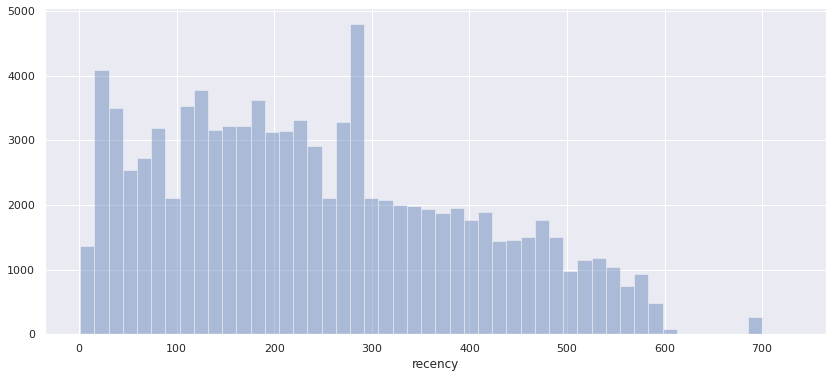

In [52]:
sns.set(rc={'figure.figsize':(14, 6)})
sns.distplot(rfm.recency, kde=False)

In [53]:
print(rfm.recency.quantile(q=0.33))
print(rfm.recency.quantile(q=0.66))

153.0
292.0


Разобъем Recency на три периода. Последний будет лежать за отметкой в 292 дня, как показал нам квантиль=0.66, зраница первого закончится чуть раньше квантиля в 0.33, судя по графику это где-то между 90-100 днями, возьмем 90, будем считать 3 месяца максимальным возрастом для наших "молодых" пользователей

In [54]:
def R(recency):
    if recency <= 90:
        return 3
    elif recency > 292:
        return 1
    else:
        return 2

rfm['r'] = rfm.recency.apply(R)

In [55]:
# почти 88% покупателей совершили только 1 покупку
print(rfm.frequency.value_counts().to_list()[0] / sum(rfm.frequency.value_counts().to_list()[:]))

0.8757251297600623


Поступим также с Frequency - разобъем на три группы. 1 - 1 покупка, 2 - 2 покупки, 3 - 3+ покупок

In [56]:
def F(frequency):
    if frequency == 1:
        return 1
    elif frequency == 2:
        return 2
    else:
        return 3

rfm['f'] = rfm.frequency.apply(F)

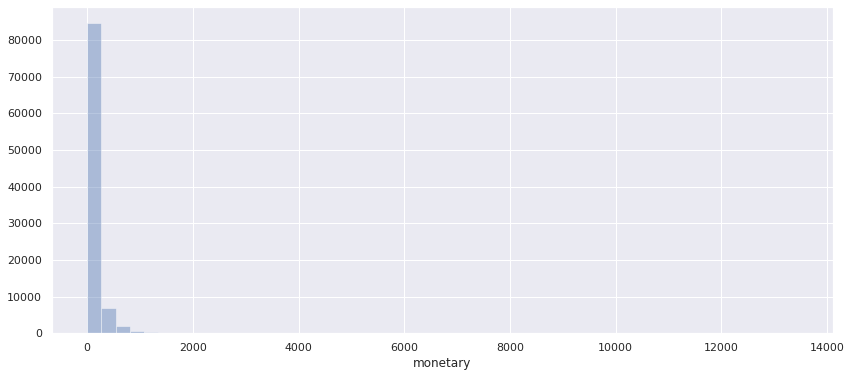

In [57]:
sns.distplot(rfm.monetary, kde=False)

In [58]:
rfm.monetary.describe()

count    94983.000000
mean       142.071747
std        216.074999
min          0.850000
25%         47.900000
50%         89.890000
75%        155.000000
max      13440.000000
Name: monetary, dtype: float64

In [59]:
# как вариант, присвоить новый столбец m можно было бы следующим образом:
# m_labels = range(1, 4)

# m_groups = pd.qcut(rfm['monetary'], q=3, labels=m_labels)

# rfm = rfm.assign(m = m_groups.values)

# но мне не совсем кажется правильным, что получаются практически одинаковые группы покупателей :(
# Поэтому опять попробуем пользоваться интуицией и логикой, немного подкрепленной данными выше
# Пускай 1 - тратят до 100 у.е., 2 - от 100 до тысяч, 3 - все остальные, тогда:

def M(monetary):
    if monetary <= 100:
        return 1
    elif monetary > 1000:
        return 3
    else:
        return 2

rfm['m'] = rfm.monetary.apply(M)

In [60]:
rfm['RFM'] = rfm['r'].astype(str) + rfm['f'].astype(str) + rfm['m'].astype(str)

In [61]:
rfm.head() # наш первый ответ - результирующая таблица по каждому покупателю, с отношением его к определенному RFM-кластеру

,customer_unique_id,recency,frequency,monetary,r,f,m,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,2,1,2,212
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,2,1,1,211
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,2,112


In [62]:
# Разобъем на группы со средними значениями по каждой метрике
rfm_grouped = rfm.groupby('RFM').agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean'}).round(1)
#rfm_grouped - 27 кластеров

In [63]:
# сделаем маленький дф для визуализации
rfm_graph = rfm.groupby('RFM', as_index=False) \
               .agg({'customer_unique_id': 'count'}) \
               .rename(columns={'customer_unique_id': 'Num_of_customers'})
rfm_graph

,RFM,Num_of_customers
0,111,17547
1,112,10416
2,113,289
3,121,1194
4,122,1767
5,123,30
6,131,170
7,132,713
8,133,34
9,211,23644


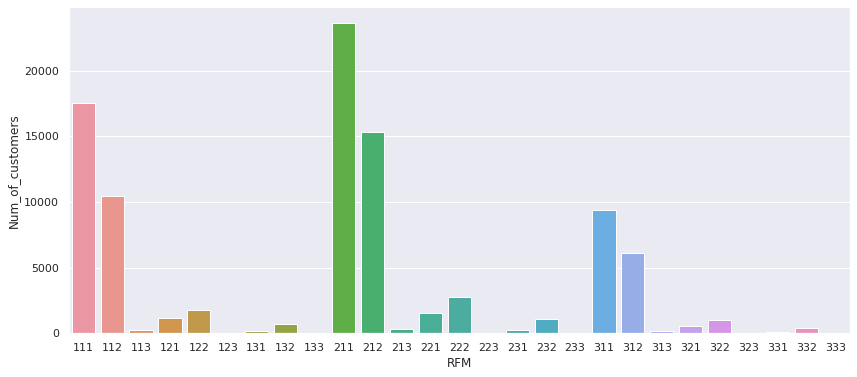

In [64]:
sns.barplot(data=rfm_graph, x='RFM', y='Num_of_customers')

**Работа выполнена и оценена в 70 баллов из 70**